# *Matrix Factorization using Last.fm data*

# Imports

In [1]:
!pip install torch seaborn matplotlib pandas numpy

In [2]:
import math
import time
import sys
import pickle

import numpy as np
import pandas as pd

import torch
from torch.distributions import Normal
from torch.nn.functional import softplus

In [3]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    env = torch.cuda
    device = torch.device('cuda')
    print("Using GPU")
else:
    torch.set_default_tensor_type('torch.FloatTensor')
    env = torch
    device = torch.device('cpu')
    print("Using CPU")

Using CPU


In [4]:
from aux import print2, tonumpy, tonumpy2, flatten_first_two_dims, assert_valid, dict2str, parse_script_args
import aux_time

In [5]:
import losses
import utility_term_estimation
import optimal_decisions
import evaluation 

[Evaluation] Results of optimal_h_for_risk will be cached.


In [6]:
from importlib import reload  
reload(losses)
reload(evaluation)
reload(utility_term_estimation)
reload(optimal_decisions)

[Evaluation] Results of optimal_h_for_risk will be cached.


<module 'optimal_decisions' from '/home/local/user/Dropbox/prj_viLoss/src/optimal_decisions.py'>

# Configuration

In [7]:
args = parse_script_args() # arguments can be passed in the format of NAME1=FLOATVAL1,NAME2=[STRVAL2],NAME3=INTVAL3,...

parsing: <-f>


In [8]:
# optimization general parmeters
SEED = args.get("SEED", 0)
NITER  = 30001 # number of iterations - around 70k is the right number for mininbatch=10
LR = 0.01 # 0.1 is the right number for the full batch, 0.001 is advised for mininbatch=10
MINIBATCH = 100 # how many rows of the matrix per minibatch

# model parameter
K = 20 # number of latent variables

# number of samples used to approximate ELBO term
NSAMPLES = 11

In [9]:
# selected loss: tilted/squared/exptilted/expsquared
LOSS = args.get("LOSS", "squared")
TILTED_Q = args.get("TILTED_Q", 0.2) # relevant only for tilted and exptilted

# loss-to-utility transformation (bigM: utility=M-loss / id: utility=-loss / expsquared=exptilted=1.0-loss)
UTIL = args.get("UTIL", "exp")
M = args.get("M", 10000.0 if UTIL.lower()=="bigm" else 1.0) # optimally should be fixed to match a quantile
GAMMA = 1.0/M # matters only for UTIL=exp; should be fixed manually to match a quantile

In [10]:
# constructing an approximation to the utility-dependent term:
UTILITY_TERM = args.get("UTILITY_TERM", "naive") # vi/naive/linearized/jensen
# the utility-dependent term is multiplied by this value: 
# should be different from 1.0 only for UTILITY_TERM = "linearized"
UTILITY_TERM_SCALE = args.get("UTILITY_TERM_SCALE", (1.0/M if "linear" in UTILITY_TERM else 1.0))  

# how many samples of latent variables
NSAMPLES_UTILITY_TERM_THETA = 300
# how many samples of y for each latent variable
NSAMPLES_UTILITY_TERM_Y = 1

In [11]:
# how often to evaulate (=report losses and (optionally) gains)
EVAL_NITER = 3000

# Usually to evaluate risks we rely on Bayes estimators whereas for gains we use numerical optimization.
GAIN_OPTIMAL_H_NUMERICALLY = False # If set to False, Bayes estimators will be used for evaluation
RISK_OPTIMAL_H_NUMERICALLY = False # otherwise numerical (slow) optimization is used

# evaluation parameters (these numbers should be sufficently large 
# if we want to trust our evaluation):
#  number of samples of latent variables
EVAL_NSAMPLES_UTILITY_TERM_THETA = 1000
#  number of samples of y for each latent variable
EVAL_NSAMPLES_UTILITY_TERM_Y = 1
# parameters of the numerical optimization w.r.t. h used in evaluation
EVAL_MAX_NITER = 20000
EVAL_SGD_PREC = 0.0001

In [12]:
print("CONFIGURATION SUMMARY: %s" % dict2str(globals()))

CONFIGURATION SUMMARY: EVAL_MAX_NITER=20000 EVAL_NITER=3000 EVAL_NSAMPLES_UTILITY_TERM_THETA=1000 EVAL_NSAMPLES_UTILITY_TERM_Y=1 EVAL_SGD_PREC=0.0001 K=20 LOSS=squared LR=0.01 M=1.0 MINIBATCH=100 NITER=30001 NSAMPLES=11 NSAMPLES_UTILITY_TERM_THETA=300 NSAMPLES_UTILITY_TERM_Y=1 SEED=0 TILTED_Q=0.2 UTIL=exp UTILITY_TERM=naive UTILITY_TERM_SCALE=1.0


# Data

In [13]:
def lastfm_data(N=1000, D=100, url="data/lastfm_data.csv"):    
    """LastFm views."""
    df = pd.read_csv(url, header=None)
    x_ = df.values #users in rows, artists in colums
    x_ = x_[:N, :D]
    N, D = x_.shape

    x_ = np.log(1+x_)
    mask_ = np.ones( (N,D), dtype=bool) #non-missing values
    return x_, mask_

In [14]:
# Prepares data to work with pytorch
x_, mask_ = lastfm_data()
x    = torch.tensor(x_, dtype = torch.float, requires_grad=False)
mask = torch.tensor(mask_.astype(np.uint8)).type(env.ByteTensor) # non-missing values
N, D = x.shape

## Training vs. test split

In [15]:
def random_mask(x, testing_prob=0.5, seed=123): 
    np.random.seed(seed)
    N, D = x.shape
    testing_mask = np.random.choice([0, 1], (N, D), (1.0-testing_prob, testing_prob))
    training_mask = np.ones((N, D))-testing_mask
    return training_mask, testing_mask

In [16]:
# Prepares masks to work with pytorch
training_mask, testing_mask = random_mask(x)
training_mask = torch.tensor((training_mask*mask_).astype(np.uint8)).type(env.ByteTensor)
testing_mask  = torch.tensor((testing_mask*mask_).astype(np.uint8)).type(env.ByteTensor)
N, D = training_mask.shape

# Model

In [17]:
def jacobian_softplus(x):
       return 1.0/(1.0 + torch.exp(-x))
    
    
def model_log_prob(x, w, z, mask=None, sgd_scale=1.0):
    if mask is None: mask = torch.ones_like(x).type(env.ByteTensor)
    
    xhat = z.matmul(w)
    likelihood = Normal(xhat, 1.) 
    prior = Normal(0, 10)
    assert likelihood.loc.shape[1: ] == x.shape
    
    return torch.masked_select(likelihood.log_prob(x), mask).sum()*sgd_scale \
            + prior.log_prob(w).sum() + prior.log_prob(z).sum()*sgd_scale

## Sampling from predictive posterior distribution

In [18]:
def sample_predictive_y0(qw, qz, nsamples_theta, nsamples_y):  
    """ Returns a tensor with samples     
        (nsamples_y samples of y for each theta x 
         nsamples_theta samples of latent variables)."""
    w = qw.rsample(torch.Size([nsamples_theta]))
    z = qz.rsample(torch.Size([nsamples_theta]))    
    
    xhat = z.matmul(w)
    likelihood = Normal(xhat, 1.)
    y_samples = likelihood.rsample(torch.Size([nsamples_y]))
    return y_samples


def sample_predictive_y(qw, qz, nsamples_theta, nsamples_y):  
    """ Returns a tensor with samples (nsamples_y x nsamples_theta).
        Flattents the first two dimensions 
        (samples of y for different thetas) from sample_predictive_y0.
    """
    return flatten_first_two_dims(sample_predictive_y0(qw, qz, nsamples_theta, nsamples_y))

# Preparing losses, utilities and Bayes estimator

In [19]:
# mask used to select points to the utility-dependent term: use only training data
utility_term_mask = training_mask 
 
loss, optimal_h_bayes_estimator = losses.LossFactory(**globals()).create(LOSS)
print2("> <%s> loss: %s with (analytical/Bayes estimator) h: %s" % 
        (LOSS, loss.__name__, optimal_h_bayes_estimator.__name__))
        
u = losses.UtilityFactory(**globals()).create(UTIL, loss)
print2("> utility: %s" % u.__name__)            

[LossFactory] Configuration: TILTED_Q=0.2 LINEX_C=None
> <squared> loss: squared_loss with (analytical/Bayes estimator) h: squared_loss_optimal_h
[UtilityFactory] Configuration: M=1.0 GAMMA=1.0
> utility: uexp


In [20]:
utility_term_factory = utility_term_estimation.UtilityAggregatorFactory()

# Evaluation

In [21]:
train_measures = evaluation.Measures(
                 x, loss, u, 
                 sample_predictive_y, 
                 optimal_h_bayes_estimator=optimal_h_bayes_estimator,
                 y_mask=training_mask,
                 GAIN_OPTIMAL_H_NUMERICALLY = GAIN_OPTIMAL_H_NUMERICALLY,
                 RISK_OPTIMAL_H_NUMERICALLY = RISK_OPTIMAL_H_NUMERICALLY,
                 EVAL_NSAMPLES_UTILITY_TERM_THETA = EVAL_NSAMPLES_UTILITY_TERM_THETA,
                 EVAL_NSAMPLES_UTILITY_TERM_Y = EVAL_NSAMPLES_UTILITY_TERM_Y,
                 EVAL_MAX_NITER = EVAL_MAX_NITER,
                 EVAL_SGD_PREC = EVAL_SGD_PREC) 


test_measures = evaluation.Measures(
                 x, loss, u, 
                 sample_predictive_y, 
                 optimal_h_bayes_estimator=optimal_h_bayes_estimator,
                 y_mask=testing_mask,
                 GAIN_OPTIMAL_H_NUMERICALLY = GAIN_OPTIMAL_H_NUMERICALLY,
                 RISK_OPTIMAL_H_NUMERICALLY = RISK_OPTIMAL_H_NUMERICALLY,
                 EVAL_NSAMPLES_UTILITY_TERM_THETA = EVAL_NSAMPLES_UTILITY_TERM_THETA,
                 EVAL_NSAMPLES_UTILITY_TERM_Y = EVAL_NSAMPLES_UTILITY_TERM_Y,
                 EVAL_MAX_NITER = EVAL_MAX_NITER,
                 EVAL_SGD_PREC = EVAL_SGD_PREC) 

[Evaluation] Configuration: y=torch.Size([992, 100]) y_mask=torch.Size([992, 100]) loss=squared_loss utility=uexp sample_predictive_y=sample_predictive_y optimal_h_bayes_estimator=squared_loss_optimal_h GAIN_OPTIMAL_H_NUMERICALLY=False RISK_OPTIMAL_H_NUMERICALLY=False EVAL_NSAMPLES_UTILITY_TERM_THETA=1000 EVAL_NSAMPLES_UTILITY_TERM_Y=1 EVAL_MAX_NITER=20000 EVAL_SGD_PREC=0.0001 EVAL_LR=0.01
[Evaluation] Results of optimal_h_for_gain will be cached.
[Evaluation] Results of optimal_h_for_risk will be cached.
[Evaluation] Results of sample_predictive_posterior will be cached.
[Evaluation] Configuration: y=torch.Size([992, 100]) y_mask=torch.Size([992, 100]) loss=squared_loss utility=uexp sample_predictive_y=sample_predictive_y optimal_h_bayes_estimator=squared_loss_optimal_h GAIN_OPTIMAL_H_NUMERICALLY=False RISK_OPTIMAL_H_NUMERICALLY=False EVAL_NSAMPLES_UTILITY_TERM_THETA=1000 EVAL_NSAMPLES_UTILITY_TERM_Y=1 EVAL_MAX_NITER=20000 EVAL_SGD_PREC=0.0001 EVAL_LR=0.01
[Evaluation] Results of opti

# Minibatch optimization

In [22]:
def yield_minibatch_rows(i, N, MINIBATCH):
    """ Minibatch optimization via rows subset selection.
    
        Args:
          i  Iteration number 0,1,2,...
    """
    if MINIBATCH>N: MINIBATCH=N

    nbatches_per_epoch = int( np.ceil(N/MINIBATCH) )
    batch_no = i%nbatches_per_epoch    
    if batch_no==0: # shuffle order
        yield_minibatch_rows.rows_order = np.random.permutation(range(N))
    six, eix = batch_no*MINIBATCH, (batch_no+1)*MINIBATCH
    rows = yield_minibatch_rows.rows_order[six: eix] # batch rows
    
    # makes sure that for full-batch the order of rows is preserved
    if MINIBATCH>=N: rows = list(range(N)) 
      
    sgd_scale = N/len(rows) 
    epoch_no = i//nbatches_per_epoch
    return rows, epoch_no, sgd_scale
yield_minibatch_rows.rows_order = None  

# Standard mean-field VI

In [23]:
torch.manual_seed(SEED)

qz_loc = torch.randn([N, K], requires_grad=True)
qz_scale = torch.randn([N, K], requires_grad=True)
qw_loc = torch.randn([K, D], requires_grad=True)
qw_scale = torch.randn([K, D], requires_grad=True)

optimizer = torch.optim.Adam([qw_loc, qw_scale, qz_loc, qz_scale], lr=LR) 

In [24]:
report = []
losses = []
start = time.time()    
for i in range(NITER):
    with aux_time.AccumulatingTimer("VI"):
    
        rows, epoch_no, sgd_scale = yield_minibatch_rows(i, N, MINIBATCH)
        if i<20 or i%500==0: print2("[%.2fs] %i. iteration, %i. epoch" % (time.time()-start, i, epoch_no))

        #######################################################        
        # preparation: selecting minibatch rows

        qz_loc0 = qz_loc[rows, :]
        qz_scale0 = qz_scale[rows, :]    
        qw = Normal(qw_loc, softplus(qw_scale))
        qz = Normal(qz_loc0, softplus(qz_scale0))

        x0 = x[rows,:]
        training_mask0 = training_mask[rows, :]

        #######################################################
        # optimization

        w = qw.rsample(torch.Size([NSAMPLES]))
        z = qz.rsample(torch.Size([NSAMPLES]))
        elbo = model_log_prob(x0, w, z, training_mask0, sgd_scale).sum() \
                        -qw.log_prob(w).sum() -qz.log_prob(z).sum()*sgd_scale 
        elbo = elbo/NSAMPLES

        optimizer.zero_grad()            
        objective = -elbo 
        objective.backward(retain_graph=False)
        optimizer.step()    
    
    #######################################################
    # reporting
    
    if (i>0) and (i%EVAL_NITER==0 or i==NITER-1): #report results
        print("evaluating (performed on the full data batch; may take some time)...")        
        qw = Normal(qw_loc, softplus(qw_scale))
        qz = Normal(qz_loc, softplus(qz_scale))
            
        ys = sample_predictive_y(qw, qz, nsamples_theta=100, nsamples_y=1)        
        h = optimal_h_bayes_estimator(ys)
        losses.append(loss(h,ys))
            
        rmse = (qz.rsample(torch.Size([])).mm(qw.rsample(torch.Size([])))-x)**2
        training_rmse = torch.masked_select(rmse, training_mask).mean()
        testing_rmse = torch.masked_select(rmse, testing_mask).mean() 
            
        r = (aux_time.AccumulatingTimer.get_elapsed("VI"),
                 "VI", SEED, i, epoch_no,
                 elbo.item(), 
                 training_rmse.item(), 
                 train_measures.qrisk(qw, qz).item(), 
                 train_measures.empirical_risk(qw, qz).item(),
                 train_measures.qgain(qw, qz).item(), 
                 train_measures.empirical_gain(qw, qz).item(),
                 testing_rmse.item(),  
                 test_measures.qrisk(qw, qz).item(),  
                 test_measures.empirical_risk(qw, qz).item(),
                 test_measures.qgain(qw, qz).item(),  
                 test_measures.empirical_gain(qw, qz).item(),
                 qw_loc.mean().item(), softplus(qw_scale).mean().item(), 
                 qz_loc.mean().item(), softplus(qz_scale).mean().item(),
                 qw_loc.std().item(),  softplus(qw_scale).std().item(), 
                 qz_loc.std().item(),  softplus(qz_scale).std().item())        
        report.append(r) # append to report            
        print("[%.1fs][%s][%s][%s][%s] elbo: %.2f;   TRAINING: rmse:%.4f  qRisk:%.4f eRisk:%.4f \t\t\t \
                qGain:%.4f eGain:%.4f;  \t\t\t TEST: rmse:%.4f  qRisk: %4f eRisk: %.4f \
                qGain:%.4f eGain:%.4f  qw:%.3f+/-%.3f qz:%.3f+/-%.3f" % (r[:20]))                                
        
        assert_valid(qw.loc); 
        assert_valid(qz.loc); 
        assert_valid(qw.scale); 
        assert_valid(qz.scale); 
        
        # store report to a CSV file
        LOSSSTR = (("%s%s" % (LOSS, TILTED_Q)) if "tilted" in LOSS else LOSS)
        OUT = "MF_VI_%i_%s_%s" % (SEED, LOSSSTR, UTIL)
        pd.DataFrame(report).to_csv(OUT+".csv", header=False, index=False)        
        
report_vi = report    
qw_vi = Normal(qw_loc, softplus(qw_scale))
qz_vi = Normal(qz_loc, softplus(qz_scale))

[0.00s] 0. iteration, 0. epoch
[0.02s] 1. iteration, 0. epoch
[0.04s] 2. iteration, 0. epoch
[0.08s] 3. iteration, 0. epoch
[0.09s] 4. iteration, 0. epoch
[0.11s] 5. iteration, 0. epoch
[0.15s] 6. iteration, 0. epoch
[0.17s] 7. iteration, 0. epoch
[0.21s] 8. iteration, 0. epoch
[0.23s] 9. iteration, 0. epoch
[0.27s] 10. iteration, 1. epoch
[0.30s] 11. iteration, 1. epoch
[0.32s] 12. iteration, 1. epoch
[0.34s] 13. iteration, 1. epoch
[0.36s] 14. iteration, 1. epoch
[0.37s] 15. iteration, 1. epoch
[0.39s] 16. iteration, 1. epoch
[0.40s] 17. iteration, 1. epoch
[0.42s] 18. iteration, 1. epoch
[0.44s] 19. iteration, 1. epoch
[8.49s] 500. iteration, 50. epoch
[17.29s] 1000. iteration, 100. epoch
[26.37s] 1500. iteration, 150. epoch
[37.40s] 2000. iteration, 200. epoch
[46.92s] 2500. iteration, 250. epoch
[54.05s] 3000. iteration, 300. epoch
evaluating (performed on the full data batch; may take some time)...
[Evaluation] Recalculating and memorizing result of sample_predictive_posterior
[E

[Evaluation] Recalculating and memorizing result of sample_predictive_posterior
[Evaluation] Recalculating and memorizing result of optimal_h_for_risk
[Evaluation] Recalculating and memorizing result of optimal_h_for_risk
[Evaluation:optimal_h_for_risk] h=tensor([[ 7.4908e+00,  5.1171e+00,  4.9887e+00,  ...,  2.9936e+00,
          2.9767e+00,  7.5916e-01],
        [ 7.9724e+00,  8.1834e+00,  3.4915e+00,  ...,  4.1058e+00,
          9.7908e-01,  3.2464e
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_risk
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Recalculating and memorizing result of optimal_h_for_gain
[Evaluation:optimal_h_for_gain] h=tensor([[ 7.4908e+00,  5.1171e+00,  4.9887e+00,  ...,  2.9936e+00,
          2.9767e+00,  7.5916e-01],
        [ 7.9724e+00,  8.1834e+00,  3.4915e+00,  ...,  4.1058e+00,
     

[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_gain
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_risk
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_risk
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_gain
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_gain
[337.0s][VI][0][21000][2100] elbo: -98176.18;   TRAINING: rmse:1.1072  qRisk:1.3224 eRisk:0.7824 			                 qGain:0.5244 eGain:0.6924;  			 TEST: rmse:2

# LCVI using joint optimization of decisions and parameters

In [25]:
utility_term = utility_term_factory.create(UTILITY_TERM)
print2("> utility_term: %s" % utility_term.__name__)  

[UtilityAggregatorFactory] creating naive (a=None, b=None)
> utility_term: utility_term_naive


In [26]:
torch.manual_seed(SEED)

qz_loc = torch.randn([N, K], requires_grad=True)
qz_scale = torch.randn([N, K], requires_grad=True)
qw_loc = torch.randn([K, D], requires_grad=True)
qw_scale = torch.randn([K, D], requires_grad=True)

h = torch.randn((N, D), requires_grad=True)

optimizer = torch.optim.Adam([qw_loc, qw_scale, qz_loc, qz_scale, h], lr=LR) 

In [27]:
report = []
start = time.time()    
for i in range(NITER):
    with aux_time.AccumulatingTimer("LCVI"):
    
        rows, epoch_no, sgd_scale = yield_minibatch_rows(i, N, MINIBATCH)
        if i<20 or i%500==0: print2("[%.2fs] %i. iteration, %i. epoch" % (time.time()-start, i, epoch_no))

        #######################################################        
        # preparation: selecting minibatch rows

        qz_loc0 = qz_loc[rows, :]
        qz_scale0 = qz_scale[rows, :]    
        qw = Normal(qw_loc, softplus(qw_scale))
        qz = Normal(qz_loc0, softplus(qz_scale0))

        h0 = h[rows,:]
        x0 = x[rows,:]
        training_mask0 = training_mask[rows, :]
        utility_term_mask0 = utility_term_mask[rows, :] 

        #######################################################
        # optimization

        w = qw.rsample(torch.Size([NSAMPLES]))
        z = qz.rsample(torch.Size([NSAMPLES]))
        elbo = model_log_prob(x0, w, z, training_mask0, sgd_scale).sum() \
                        -qw.log_prob(w).sum() -qz.log_prob(z).sum()*sgd_scale 
        elbo = elbo/NSAMPLES

        ys = sample_predictive_y0(qw, qz, 
                                  nsamples_theta=NSAMPLES_UTILITY_TERM_THETA,
                                  nsamples_y=NSAMPLES_UTILITY_TERM_Y)        

        optimizer.zero_grad()            
        objective = -elbo -utility_term(u(h0,ys), utility_term_mask0)*UTILITY_TERM_SCALE*sgd_scale
        objective.backward(retain_graph=False)
        optimizer.step()    
    
    #######################################################
    # reporting
    
    if (i>0) and (i%EVAL_NITER==0 or i==NITER-1): #report results
        print("evaluating (performed on the full data batch; may take some time)...")        
        qw = Normal(qw_loc, softplus(qw_scale))
        qz = Normal(qz_loc, softplus(qz_scale))
            
        rmse = (qz.rsample(torch.Size([])).mm(qw.rsample(torch.Size([])))-x)**2
        training_rmse = torch.masked_select(rmse, training_mask).mean()
        testing_rmse = torch.masked_select(rmse, testing_mask).mean() 
            
        r = (aux_time.AccumulatingTimer.get_elapsed("LCVI"),
                 utility_term.__name__, SEED, i, epoch_no,
                 elbo.item(), 
                 training_rmse.item(), 
                 train_measures.qrisk(qw, qz).item(), 
                 train_measures.empirical_risk(qw, qz).item(),
                 train_measures.qgain(qw, qz).item(), 
                 train_measures.empirical_gain(qw, qz).item(),
                 testing_rmse.item(),  
                 test_measures.qrisk(qw, qz).item(),  
                 test_measures.empirical_risk(qw, qz).item(),
                 test_measures.qgain(qw, qz).item(),  
                 test_measures.empirical_gain(qw, qz).item(),
                 qw_loc.mean().item(), softplus(qw_scale).mean().item(), 
                 qz_loc.mean().item(), softplus(qz_scale).mean().item(),
                 qw_loc.std().item(),  softplus(qw_scale).std().item(), 
                 qz_loc.std().item(),  softplus(qz_scale).std().item())        
        report.append(r) # append to report            
        print("[%.1fs][%s][%s][%s][%s] elbo: %.2f;   TRAINING: rmse:%.4f  qRisk:%.4f eRisk:%.4f \t\t\t \
                qGain:%.4f eGain:%.4f;  \t\t\t TEST: rmse:%.4f  qRisk: %4f eRisk: %.4f \
                qGain:%.4f eGain:%.4f  qw:%.3f+/-%.3f qz:%.3f+/-%.3f" % (r[:20]))                                                               
        
        assert_valid(qw.loc); 
        assert_valid(qz.loc); 
        assert_valid(qw.scale); 
        assert_valid(qz.scale);  
        
        # store report to a CSV file        
        LOSSSTR = (("%s%s" % (LOSS, TILTED_Q)) if "tilted" in LOSS else LOSS)
        OUT = "MF_LCVI_%s%s_%i_%s_%s" % (UTILITY_TERM, UTILITY_TERM_SCALE, SEED, LOSSSTR, UTIL)
        pd.DataFrame(report).to_csv(OUT+".csv", header=False, index=False)
        
report_lcvi_jo = report  
qw_lcvi_jo = Normal(qw_loc, softplus(qw_scale))
qz_lcvi_jo = Normal(qz_loc, softplus(qz_scale))
pickle.dump((qw_lcvi_jo, qz_lcvi_jo), open(OUT+".pickle", "wb"))

[0.00s] 0. iteration, 0. epoch
[0.20s] 1. iteration, 0. epoch
[0.39s] 2. iteration, 0. epoch
[0.56s] 3. iteration, 0. epoch
[0.73s] 4. iteration, 0. epoch
[0.90s] 5. iteration, 0. epoch
[1.06s] 6. iteration, 0. epoch
[1.24s] 7. iteration, 0. epoch
[1.41s] 8. iteration, 0. epoch
[1.59s] 9. iteration, 0. epoch
[1.74s] 10. iteration, 1. epoch
[1.91s] 11. iteration, 1. epoch
[2.10s] 12. iteration, 1. epoch
[2.26s] 13. iteration, 1. epoch
[2.42s] 14. iteration, 1. epoch
[2.60s] 15. iteration, 1. epoch
[2.80s] 16. iteration, 1. epoch
[2.99s] 17. iteration, 1. epoch
[3.17s] 18. iteration, 1. epoch
[3.34s] 19. iteration, 1. epoch
[86.21s] 500. iteration, 50. epoch
[166.87s] 1000. iteration, 100. epoch
[258.25s] 1500. iteration, 150. epoch
[344.82s] 2000. iteration, 200. epoch
[444.64s] 2500. iteration, 250. epoch
[541.50s] 3000. iteration, 300. epoch
evaluating (performed on the full data batch; may take some time)...
[Evaluation] Recalculating and memorizing result of sample_predictive_poster

[2297.71s] 12000. iteration, 1200. epoch
evaluating (performed on the full data batch; may take some time)...
[Evaluation] Recalculating and memorizing result of sample_predictive_posterior
[Evaluation] Recalculating and memorizing result of optimal_h_for_risk
[Evaluation] Recalculating and memorizing result of optimal_h_for_risk
[Evaluation:optimal_h_for_risk] h=tensor([[ 7.4630e+00,  5.1650e+00,  3.9202e+00,  ...,  3.0260e+00,
          2.7383e+00,  1.9487e+00],
        [ 7.4820e+00,  8.0936e+00,  2.3772e+00,  ...,  3.6219e+00,
          6.6055e-01,  2.9029e
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_risk
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Recalculating and memorizing result of optimal_h_for_gain
[Evaluation:optimal_h_for_gain] h=tensor([[ 7.4630e+00,  5.1650e+00,  3.9202e+00,  ...,  3.0260e+00

[Evaluation] Recalculating and memorizing result of optimal_h_for_gain
[Evaluation:optimal_h_for_gain] h=tensor([[ 8.4387,  6.0301,  3.5174,  ...,  2.3376,  2.6585,  1.8115],
        [ 7.4547,  7.9394,  2.7007,  ...,  3.7171,  0.9318,  3.7611],
        [ 9.0635,  7.6483,  3.3031,  ...,  3.3343,  1.2218, 
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_gain
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_risk
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_risk
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_gain
[Evaluation] Reusing previous result of sample_pre

[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_gain
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_gain
[4435.5s][utility_term_naive][0][30000][3000] elbo: -109415.45;   TRAINING: rmse:1.3095  qRisk:1.0633 eRisk:1.2431 			                 qGain:0.5656 eGain:0.6322;  			 TEST: rmse:1.7630  qRisk: 1.065582 eRisk: 1.7003                 qGain:0.5652 eGain:0.5860  qw:0.010+/-0.003 qz:0.297+/-6.534


# LCVI-EM

In [28]:
# Configuration of M-step

# finding optimal h:
#  bayes - use Bayes estimator / num-gain - optimize numerically gain / 
#  num-util - optimize numerically a selected approximation to the utility-dependent term.
FIND_H = args.get("FIND_H", "bayes") # Bayes estimator can be used only when available (for certain losses)
# choose an approximation to the utility-dependent term, 
#  by default == UTILITY_TERM (the same as for lambdas)
H_UTILITY_AGGREGATOR = UTILITY_TERM
# respectively, the number of theta and y samples used when optimizing for h; 
#  by default the same as for UTILITY_TERM
H_NSAMPLES_UTILITY_TERM_THETA = args.get("H_NSAMPLES_UTILITY_TERM_THETA", NSAMPLES_UTILITY_TERM_THETA)
H_NSAMPLES_UTILITY_TERM_Y = args.get("H_NSAMPLES_UTILITY_TERM_Y", NSAMPLES_UTILITY_TERM_Y)

# parameters of the numerical optimizer used to find the optimal h
H_NUMERICAL_MAX_NITER =  1000
H_NUMERICAL_MAX_NITER_TOL = 0.001
H_NUMERICAL_MAX_NITER_TOL_GOAL = -1
H_NUMERICAL_LR = 0.1
H_NUMERICAL_OPT_SCIPY = False
H_NUMERICAL_START_FROM_PREVIOUS = False

In [29]:
h_utility_term = utility_term_factory.create(H_UTILITY_AGGREGATOR)
print2("> decision optimizer's utility_term: %s (used only with numerical optimizers)" % h_utility_term.__name__)  

# prepares an optimizer for M-step
decision_maker =  optimal_decisions.HOptimizerFactory(**globals()).create(FIND_H, u=u, 
                                                      optimal_h_bayes_estimator=optimal_h_bayes_estimator, 
                                                      utility_aggregator=h_utility_term)
print2("> decision_maker: %s" % decision_maker.__name__)  

[UtilityAggregatorFactory] creating naive (a=None, b=None)
> decision optimizer's utility_term: utility_term_naive (used only with numerical optimizers)
[HOptimizerFactory] Configuration: H_NSAMPLES_UTILITY_TERM_THETA=300 H_NSAMPLES_UTILITY_TERM_Y=1 H_NUMERICAL_MAX_NITER=1000 H_NUMERICAL_MAX_NITER_TOL=0.001 H_NUMERICAL_MAX_NITER_TOL_GOAL=-1 H_NUMERICAL_LR=0.1 H_NUMERICAL_START_FROM_PREVIOUS=False sample_predictive_y0=sample_predictive_y0
[HOptimizerFactory] Choosing PyTorch numerical optimization.
> decision_maker: optimize_h_with_bayes_estimator


In [30]:
utility_term = utility_term_factory.create(UTILITY_TERM)
print2("> utility_term: %s" % utility_term.__name__)  

[UtilityAggregatorFactory] creating naive (a=None, b=None)
> utility_term: utility_term_naive


In [31]:
torch.manual_seed(SEED)

qz_loc = torch.randn([N, K], requires_grad=True)
qz_scale = torch.randn([N, K], requires_grad=True)
qw_loc = torch.randn([K, D], requires_grad=True)
qw_scale = torch.randn([K, D], requires_grad=True)

optimizer = torch.optim.Adam([qw_loc, qw_scale, qz_loc, qz_scale], lr=LR) 

In [32]:
report = []
start = time.time()    
for i in range(NITER):
    with aux_time.AccumulatingTimer("LCVI-EM"):

        rows, epoch_no, sgd_scale = yield_minibatch_rows(i, N, MINIBATCH)
        if i<20 or i%500==0: print2("[%.2fs] %i. iteration, %i. epoch" % (time.time()-start, i, epoch_no))

        #######################################################        
        # preparation: selecting minibatch rows

        qz_loc0 = qz_loc[rows, :]
        qz_scale0 = qz_scale[rows, :]    
        qw = Normal(qw_loc, softplus(qw_scale))
        qz = Normal(qz_loc0, softplus(qz_scale0))

        x0 = x[rows,:]
        training_mask0 = training_mask[rows, :]
        utility_term_mask0 = utility_term_mask[rows, :] 

        #######################################################
        # optimization

        w = qw.rsample(torch.Size([NSAMPLES]))
        z = qz.rsample(torch.Size([NSAMPLES]))
        elbo = model_log_prob(x0, w, z, training_mask0, sgd_scale).sum() \
                        -qw.log_prob(w).sum() -qz.log_prob(z).sum()*sgd_scale 
        elbo = elbo/NSAMPLES

        h0 = decision_maker(qw, qz)      
        ys = sample_predictive_y0(qw, qz, 
                                  nsamples_theta=NSAMPLES_UTILITY_TERM_THETA,
                                  nsamples_y=NSAMPLES_UTILITY_TERM_Y)        

        optimizer.zero_grad()            
        objective = -elbo -utility_term(u(h0, ys), utility_term_mask0)*UTILITY_TERM_SCALE*sgd_scale
        objective.backward(retain_graph=False)
        optimizer.step()    
    
    #######################################################
    # reporting
    
    if (i>0) and (i%EVAL_NITER==0 or i==NITER-1): #report results
        print("evaluating (performed on the full data batch; may take some time)...")        
        qw = Normal(qw_loc, softplus(qw_scale))
        qz = Normal(qz_loc, softplus(qz_scale))
            
        rmse = (qz.rsample(torch.Size([])).mm(qw.rsample(torch.Size([])))-x)**2
        training_rmse = torch.masked_select(rmse, training_mask).mean()
        testing_rmse = torch.masked_select(rmse, testing_mask).mean() 
            
        r = (aux_time.AccumulatingTimer.get_elapsed("LCVI-EM"),
                 utility_term.__name__, SEED, i, epoch_no,
                 elbo.item(), 
                 training_rmse.item(), 
                 train_measures.qrisk(qw, qz).item(), 
                 train_measures.empirical_risk(qw, qz).item(),
                 train_measures.qgain(qw, qz).item(), 
                 train_measures.empirical_gain(qw, qz).item(),
                 testing_rmse.item(),  
                 test_measures.qrisk(qw, qz).item(),  
                 test_measures.empirical_risk(qw, qz).item(),
                 test_measures.qgain(qw, qz).item(),  
                 test_measures.empirical_gain(qw, qz).item(),
                 qw_loc.mean().item(), softplus(qw_scale).mean().item(), 
                 qz_loc.mean().item(), softplus(qz_scale).mean().item(),
                 qw_loc.std().item(),  softplus(qw_scale).std().item(), 
                 qz_loc.std().item(),  softplus(qz_scale).std().item())        
        report.append(r) # append to report            
        print("[%.1fs][%s][%s][%s][%s] elbo: %.2f;   TRAINING: rmse:%.4f  qRisk:%.4f eRisk:%.4f \t\t\t \
                qGain:%.4f eGain:%.4f;  \t\t\t TEST: rmse:%.4f  qRisk: %4f eRisk: %.4f \
                qGain:%.4f eGain:%.4f  qw:%.3f+/-%.3f qz:%.3f+/-%.3f" % (r[:20]))                                                              
        
        assert_valid(qw.loc); 
        assert_valid(qz.loc); 
        assert_valid(qw.scale); 
        assert_valid(qz.scale); 

        # store report to a CSV file        
        LOSSSTR = (("%s%s" % (LOSS, TILTED_Q)) if "tilted" in LOSS else LOSS)
        OPTSTR = "%s_%s_%s" % (FIND_H, H_NSAMPLES_UTILITY_TERM_THETA, H_NSAMPLES_UTILITY_TERM_Y)
        OUT = "MF_LCVIEM_%s%s_%i_%s_%s_%s" % (UTILITY_TERM, UTILITY_TERM_SCALE, SEED, LOSSSTR, UTIL, OPTSTR)
        pd.DataFrame(report).to_csv(OUT+".csv", header=False, index=False)        

report_lcvi_em = report  
qw_lcvi_em = Normal(qw_loc, softplus(qw_scale))
qz_lcvi_em = Normal(qz_loc, softplus(qz_scale))

[0.00s] 0. iteration, 0. epoch
[0.21s] 1. iteration, 0. epoch
[0.39s] 2. iteration, 0. epoch
[0.56s] 3. iteration, 0. epoch
[0.73s] 4. iteration, 0. epoch
[0.90s] 5. iteration, 0. epoch
[1.06s] 6. iteration, 0. epoch
[1.23s] 7. iteration, 0. epoch
[1.40s] 8. iteration, 0. epoch
[1.57s] 9. iteration, 0. epoch
[1.72s] 10. iteration, 1. epoch
[1.89s] 11. iteration, 1. epoch
[2.05s] 12. iteration, 1. epoch
[2.23s] 13. iteration, 1. epoch
[2.39s] 14. iteration, 1. epoch
[2.56s] 15. iteration, 1. epoch
[2.74s] 16. iteration, 1. epoch
[2.91s] 17. iteration, 1. epoch
[3.08s] 18. iteration, 1. epoch
[3.25s] 19. iteration, 1. epoch
[75.33s] 500. iteration, 50. epoch
[149.79s] 1000. iteration, 100. epoch
[224.50s] 1500. iteration, 150. epoch
[298.92s] 2000. iteration, 200. epoch
[373.29s] 2500. iteration, 250. epoch
[447.66s] 3000. iteration, 300. epoch
evaluating (performed on the full data batch; may take some time)...
[Evaluation] Recalculating and memorizing result of sample_predictive_poster

evaluating (performed on the full data batch; may take some time)...
[Evaluation] Recalculating and memorizing result of sample_predictive_posterior
[Evaluation] Recalculating and memorizing result of optimal_h_for_risk
[Evaluation] Recalculating and memorizing result of optimal_h_for_risk
[Evaluation:optimal_h_for_risk] h=tensor([[ 8.2919e+00,  6.1383e+00,  3.1318e+00,  ...,  2.3025e+00,
          2.4442e+00,  1.5649e+00],
        [ 8.0196e+00,  8.3452e+00,  2.2174e+00,  ...,  3.5001e+00,
          1.0432e+00,  2.3241e
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_risk
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Recalculating and memorizing result of optimal_h_for_gain
[Evaluation:optimal_h_for_gain] h=tensor([[ 8.2919e+00,  6.1383e+00,  3.1318e+00,  ...,  2.3025e+00,
          2.4442e+00,  1.5649e+00],
   

[Evaluation] Recalculating and memorizing result of optimal_h_for_gain
[Evaluation:optimal_h_for_gain] h=tensor([[ 6.6163e+00,  5.5195e+00,  3.4950e+00,  ...,  2.3329e+00,
          2.6413e+00,  1.7082e+00],
        [ 8.6971e+00,  8.7443e+00,  2.3401e+00,  ...,  3.6204e+00,
          1.2465e+00,  3.1016e
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_gain
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_risk
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_risk
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_gain
[Evaluation] Reusing previous result of sample_pre

[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_gain
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of sample_predictive_posterior
[Evaluation] Reusing previous result of optimal_h_for_gain
[4473.8s][utility_term_naive][0][30000][3000] elbo: -103007.63;   TRAINING: rmse:1.2561  qRisk:1.0669 eRisk:1.1883 			                 qGain:0.5649 eGain:0.6384;  			 TEST: rmse:1.7555  qRisk: 1.069920 eRisk: 1.6812                 qGain:0.5644 eGain:0.5884  qw:0.009+/-0.003 qz:0.290+/-6.279


# Plots

In [33]:
from aux_plt import *
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [34]:
# Decision maker: important to set the right one! Default: use Bayes estimator.
optimal_h = optimal_h_bayes_estimator 

In [35]:
# Load data labels
ix2artist = pd.read_csv("data/lastfm_ix2artist.csv", header=None)
ix2user = pd.read_csv("data/lastfm_ix2user.csv", header=None)

ix2artist = dict(zip(ix2artist[0],ix2artist[1]))
ix2user = dict(zip(ix2user[0],ix2user[1]))

## PDFs and CDF of losses for (converged) VI

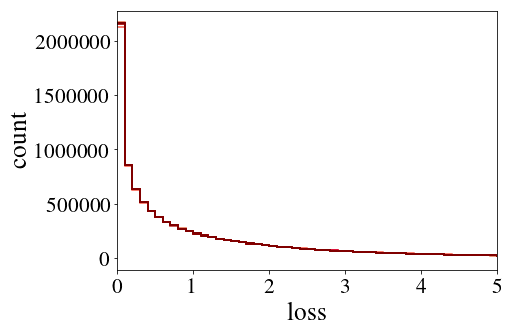

In [36]:
start_plotting(cmbright=False, font_size=17*1.5)    
epochs = pd.DataFrame(report)[4]
bins = np.arange(0, 20, 0.1)
for epoch, losses1, c in zip(epochs, losses, REDS):
    #if epoch not in [200,1000,2000,2600]: continue
    count, edges = np.histogram(tonumpy(losses1.view(-1)), bins=bins)
    plt.step(edges[:-1], count, where='post', label="epoch: %s" % epoch, color=c, lw=2)    
    #sns.kdeplot(tonumpy(losses1.view(-1)), label="epoch: %s" % epoch, gridsize=1000, color=c, lw=2)
#plt.legend()    
plt.xlim(0,5);
plt.xlabel("loss")
plt.ylabel("count")
plt.show()

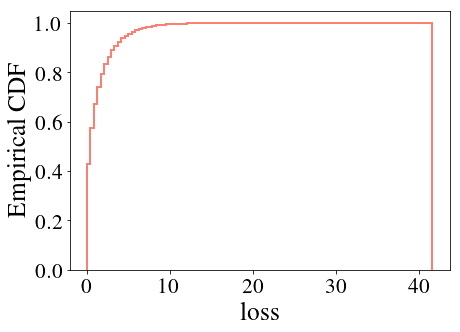

,percentile,value
0,1,0.0002
1,5,0.0051
2,10,0.0207
3,20,0.0841
4,30,0.1948
5,40,0.3605
6,50,0.5967
7,60,0.9294
8,70,1.4109
9,80,2.1591


In [37]:
losses1 = tonumpy(losses[-1].view(-1))
start_plotting(cmbright=False, font_size=17*1.5)    
n, bins, patches = plt.hist(losses1, 100, density=True, histtype='step', 
                            cumulative=True, label='Empirical', lw=2, color="salmon")
plt.xlabel("loss")
plt.ylabel("Empirical CDF")
plt.show()

percentiles = [1,5,10,20,30,40,50,60,70,80,90,95,99]
loss_values = np.percentile(losses1, percentiles)
pd.DataFrame(zip(percentiles,  np.round(loss_values,4))).rename(columns={0: "percentile", 1: "value"})

## Convergence plots

In [38]:
COLS = dict(enumerate("t, utility_term, SEED, iter, epoch, elbo, training_rmse, training_qrisk, training_erisk, training_qgain, training_egain, test_rmse, test_qrisk, test_erisk, test_qgain, test_egain".split(", ")))
report_vi_df = pd.DataFrame(report_vi).rename(columns=COLS)
report_lcvi_df = pd.DataFrame(report_lcvi_jo).rename(columns=COLS)
report_lcviem_df = pd.DataFrame(report_lcvi_em).rename(columns=COLS)

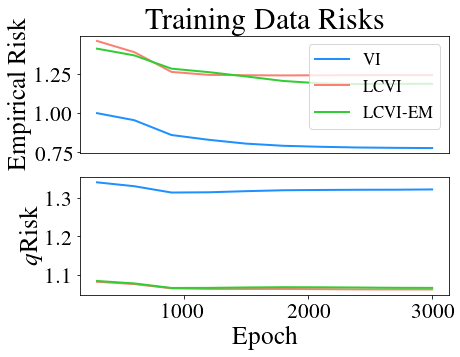

In [39]:
start_plotting(left=0.15, font_size=17*1.5, cmbright=False)
s = 2

ax1 = plt.subplot(211)
plt.title("Training Data Risks", fontsize=30)

plt.plot(report_vi_df.epoch, running_mean(report_vi_df.training_erisk, s), 
         color="dodgerblue", label="VI", lw=2);
plt.plot(report_lcvi_df.epoch, running_mean(report_lcvi_df.training_erisk, s), 
         color="salmon", label="LCVI", lw=2);
plt.plot(report_lcviem_df.epoch, running_mean(report_lcviem_df.training_erisk, s), 
         color="limegreen", label="LCVI-EM", lw=2)
plt.ylabel(r"Empirical Risk");
plt.legend(loc=1, fontsize=17);
ax1.set_xticks([],[])

ax2 = plt.subplot(212)

plt.plot(report_vi_df.epoch, running_mean(report_vi_df.training_qrisk, s), 
         color="dodgerblue", label="VI", lw=2);
plt.plot(report_lcvi_df.epoch, running_mean(report_lcvi_df.training_qrisk, s), 
         color="salmon", label="LCVI", lw=2);
plt.plot(report_lcviem_df.epoch, running_mean(report_lcviem_df.training_qrisk, s), 
         color="limegreen", label="LCVI-EM", lw=2);
plt.ylabel(r"$q$Risk($h^*$)");

plt.xlabel("Epoch");
plt.grid(False);
plt.savefig("mf_risks_iterations_training.pdf")
plt.show()

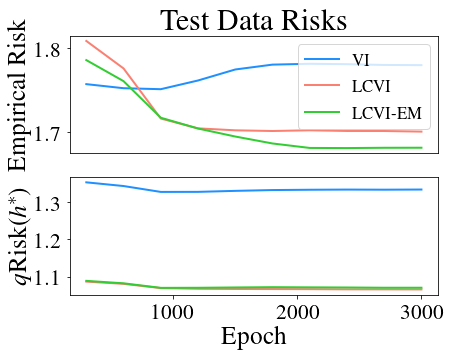

In [40]:
start_plotting(left=0.15, font_size=17*1.5, cmbright=False)
s = 2

ax1 = plt.subplot(211)
plt.title("Test Data Risks", fontsize=30)

plt.plot(report_vi_df.epoch, running_mean(report_vi_df.test_erisk, s), 
         color="dodgerblue", label="VI", lw=2);
plt.plot(report_lcvi_df.epoch, running_mean(report_lcvi_df.test_erisk, s), 
         color="salmon", label="LCVI", lw=2);
plt.plot(report_lcviem_df.epoch, running_mean(report_lcviem_df.test_erisk, s), 
         color="limegreen", label="LCVI-EM", lw=2)
plt.ylabel(r"Empirical Risk");
plt.legend(loc=1, fontsize=17);
ax1.set_xticks([],[])

ax2 = plt.subplot(212)

plt.plot(report_vi_df.epoch, running_mean(report_vi_df.test_qrisk, s), 
         color="dodgerblue", label="VI", lw=2);
plt.plot(report_lcvi_df.epoch, running_mean(report_lcvi_df.test_qrisk, s), 
         color="salmon", label="LCVI", lw=2);
plt.plot(report_lcviem_df.epoch, running_mean(report_lcviem_df.test_qrisk, s), 
         color="limegreen", label="LCVI-EM", lw=2);
plt.ylabel(r"$q$Risk($h^*$)");

plt.xlabel("Epoch");
plt.grid(False);
plt.savefig("mf_risks_iterations_test.pdf")
plt.show()

## Sample posterior (locations of latent factors)

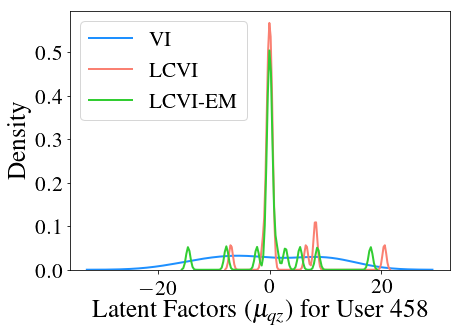

In [41]:
u = 10 # user ix
start_plotting(cmbright=False, font_size=17*1.5)    
sns.kdeplot(tonumpy(qz_vi.loc[u,:]), color="dodgerblue", shade=False, lw=2, alpha=1.0, label="VI")
sns.kdeplot(tonumpy(qz_lcvi_jo.loc[u,:]), color="salmon", shade=False, lw=2, alpha=1.0, label="LCVI")
sns.kdeplot(tonumpy(qz_lcvi_em.loc[u,:]), color="limegreen", shade=False, lw=2, alpha=1.0, label="LCVI-EM")
plt.ylabel("Density")
plt.xlabel("Latent Factors ($\mu_{qz}$) for User %s" % ix2user[u].replace("user_","").lstrip("0"))
plt.show()

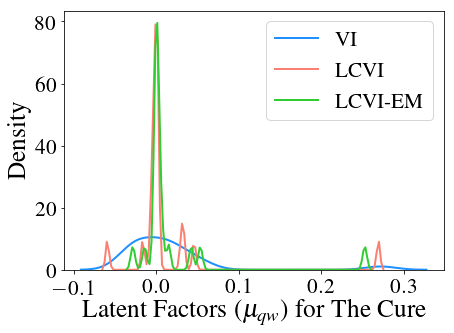

In [42]:
a = 10 # artist ix
start_plotting(cmbright=False, font_size=17*1.5)    
sns.kdeplot(tonumpy(qw_vi.loc[:,a]), color="dodgerblue", shade=False, lw=2, alpha=1.0, label="VI")
sns.kdeplot(tonumpy(qw_lcvi_jo.loc[:,a]), color="salmon", shade=False, lw=2, alpha=1.0, label="LCVI")
sns.kdeplot(tonumpy(qw_lcvi_em.loc[:,a]), color="limegreen", shade=False, lw=2, alpha=1.0, label="LCVI-EM")
plt.ylabel("Density")
plt.xlabel("Latent Factors ($\mu_{qw}$) for %s" % ix2artist[a])
plt.show()

## Sample predictive posterior

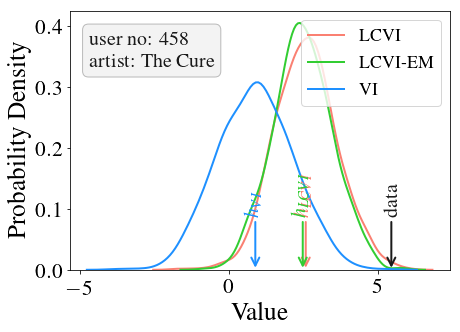

In [43]:
def _plot_cell(i, j, nsamples=1000):
    """ i is user ix and j is artist ix."""
    ys = sample_predictive_y(qw_lcvi_jo, qz_lcvi_jo, nsamples, 1)
    sns.kdeplot(tonumpy(ys[:,i,j]), color="salmon", shade=False, lw=2, alpha=1.0, label="LCVI")
    h = optimal_h(ys[:,i,j]).item()
    plt.annotate("$h_{LCVI}$", xy=(h, 0.0), xytext=(h, 0.085), rotation=90,  fontsize=20,
                     arrowprops=dict(arrowstyle="->", color="salmon", lw=2), 
                     horizontalalignment='center', verticalalignment='bottom', color="salmon")
        
    ys = sample_predictive_y(qw_lcvi_em, qz_lcvi_em, nsamples, 1)
    sns.kdeplot(tonumpy(ys[:,i,j]), color="limegreen", shade=False, lw=2, alpha=1.0, label="LCVI-EM")
    h = optimal_h(ys[:,i,j]).item()
    plt.annotate("$h_{LCVI}$", xy=(h, 0.0), xytext=(h, 0.085), rotation=90,  fontsize=20,
                     arrowprops=dict(arrowstyle="->", color="limegreen", lw=2), 
                     horizontalalignment='center', verticalalignment='bottom', color="limegreen")    

    ys = sample_predictive_y(qw_vi, qz_vi, nsamples, 1)
    sns.kdeplot(tonumpy(ys[:,i,j]), color="dodgerblue", shade=False, lw=2, alpha=1.0, label="VI")
    h = optimal_h(ys[:,i,j]).item()
    plt.annotate("$h_{VI}$", xy=(h, 0.0), xytext=(h, 0.085), rotation=90, fontsize=20,
                     arrowprops=dict(arrowstyle="->", color="dodgerblue", lw=2), 
                     horizontalalignment='center', verticalalignment='bottom', color="dodgerblue")

    h  = x[i, j]
    plt.annotate("data", xy=(h, 0.0), xytext=(h, 0.085), rotation=90, fontsize=20,
                     arrowprops=dict(arrowstyle="->", color="k", lw=2), 
                     horizontalalignment='center', verticalalignment='bottom', color="k")

    y1, y2 = plt.ylim()
    x1, x2 = plt.xlim()
    plt.text(x1+(x2-x1)*0.05, y2-(y2-y1)*0.075,
             "user no: %s\nartist: %s" % (ix2user[i].replace("user_", "").lstrip("0"), 
                                          ix2artist[j].replace("_", " ")),
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.25),
                     horizontalalignment='left', verticalalignment='top', color="k", fontsize=20)

    
start_plotting(cmbright=False, font_size=17*1.5)    
_plot_cell(10, 10) # choose user and artist ix
plt.ylabel("Probability Density")
plt.xlabel("Value")
plt.legend(loc=1, fontsize= 18)
#plt.savefig("mf_sample_posterior_predictive.pdf")
#plt.savefig("mf_sample_posterior_predictive2.pdf", bbox_inches='tight')
plt.show()

## Change in decisions

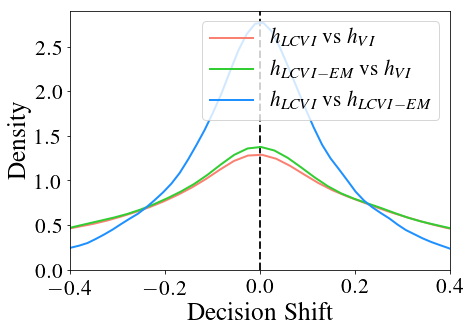

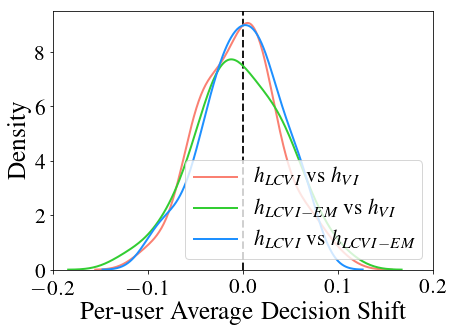

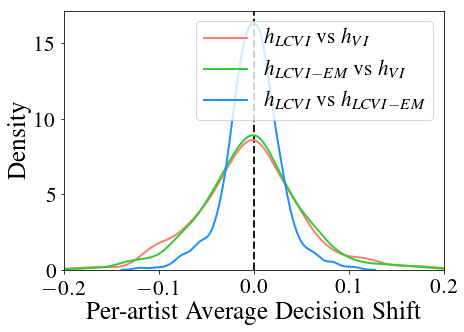

In [44]:
def _plot_h_diffs(qw0, qz0, qw1, qz1, avgdim=-1, nsamples=1000,
                  color="dodgerblue", label="differences"):
    ys_lcvi = sample_predictive_y(qw0, qz0, nsamples, 1)
    h0 = optimal_h(ys_lcvi)        
    ys_lcvi = sample_predictive_y(qw1, qz1, nsamples, 1)
    h1 = optimal_h(ys_lcvi)    
    d = (h1-h0) if avgdim<0 else (h1-h0).mean(avgdim)
    
    sns.kdeplot(tonumpy(d.view(-1)), 
                color=color, label=label, facecolor=color,
                shade=False, lw=2, alpha=1.0, gridsize=200, bw="scott")
    
    
def _plot_aux(halfwidth=2):    
    plt.axvline(x=0, color="k", ls="--", lw=2)
    plt.xlim(-halfwidth, +halfwidth)   
    plt.grid(False)

    
start_plotting(cmbright=False, font_size=17*1.5); _plot_aux(0.4)
_plot_h_diffs(qw_vi, qz_vi, qw_lcvi_jo, qz_lcvi_jo, 
                  color="salmon", label="$h_{LCVI}$ vs $h_{VI}$")
_plot_h_diffs(qw_vi, qz_vi, qw_lcvi_em, qz_lcvi_em, 
                  color="limegreen", label="$h_{LCVI-EM}$ vs $h_{VI}$")
_plot_h_diffs(qw_lcvi_em, qz_lcvi_em, qw_lcvi_jo, qz_lcvi_jo, 
                  color="dodgerblue", label="$h_{LCVI}$ vs $h_{LCVI-EM}$")
plt.xlabel("Decision Shift")
plt.ylabel("Density")
plt.show()    

start_plotting(cmbright=False, font_size=17*1.5); _plot_aux(0.2)  
_plot_h_diffs(qw_vi, qz_vi, qw_lcvi_jo, qz_lcvi_jo, avgdim=0, 
                  color="salmon", label="$h_{LCVI}$ vs $h_{VI}$")
_plot_h_diffs(qw_vi, qz_vi, qw_lcvi_em, qz_lcvi_em,  avgdim=0,
                  color="limegreen", label="$h_{LCVI-EM}$ vs $h_{VI}$")
_plot_h_diffs(qw_lcvi_em, qz_lcvi_em, qw_lcvi_jo, qz_lcvi_jo,  avgdim=0,
                  color="dodgerblue", label="$h_{LCVI}$ vs $h_{LCVI-EM}$")
plt.xlabel("Per-user Average Decision Shift")
plt.ylabel("Density")
plt.show()    

start_plotting(cmbright=False, font_size=17*1.5); _plot_aux(0.2)
_plot_h_diffs(qw_vi, qz_vi, qw_lcvi_jo, qz_lcvi_jo, avgdim=1, 
                  color="salmon", label="$h_{LCVI}$ vs $h_{VI}$")
_plot_h_diffs(qw_vi, qz_vi, qw_lcvi_em, qz_lcvi_em,  avgdim=1,
                  color="limegreen", label="$h_{LCVI-EM}$ vs $h_{VI}$")
_plot_h_diffs(qw_lcvi_em, qz_lcvi_em, qw_lcvi_jo, qz_lcvi_jo,  avgdim=1,
                  color="dodgerblue", label="$h_{LCVI}$ vs $h_{LCVI-EM}$")
plt.xlabel("Per-artist Average Decision Shift")
plt.ylabel("Density")
plt.show() 